In [1]:
!pip install matplotlib numpy

In [2]:
!python -m pip install pennylane pennylane-lightning pennylane-lightning-gpu --upgrade

In [3]:
!pip install custatevec-cu12

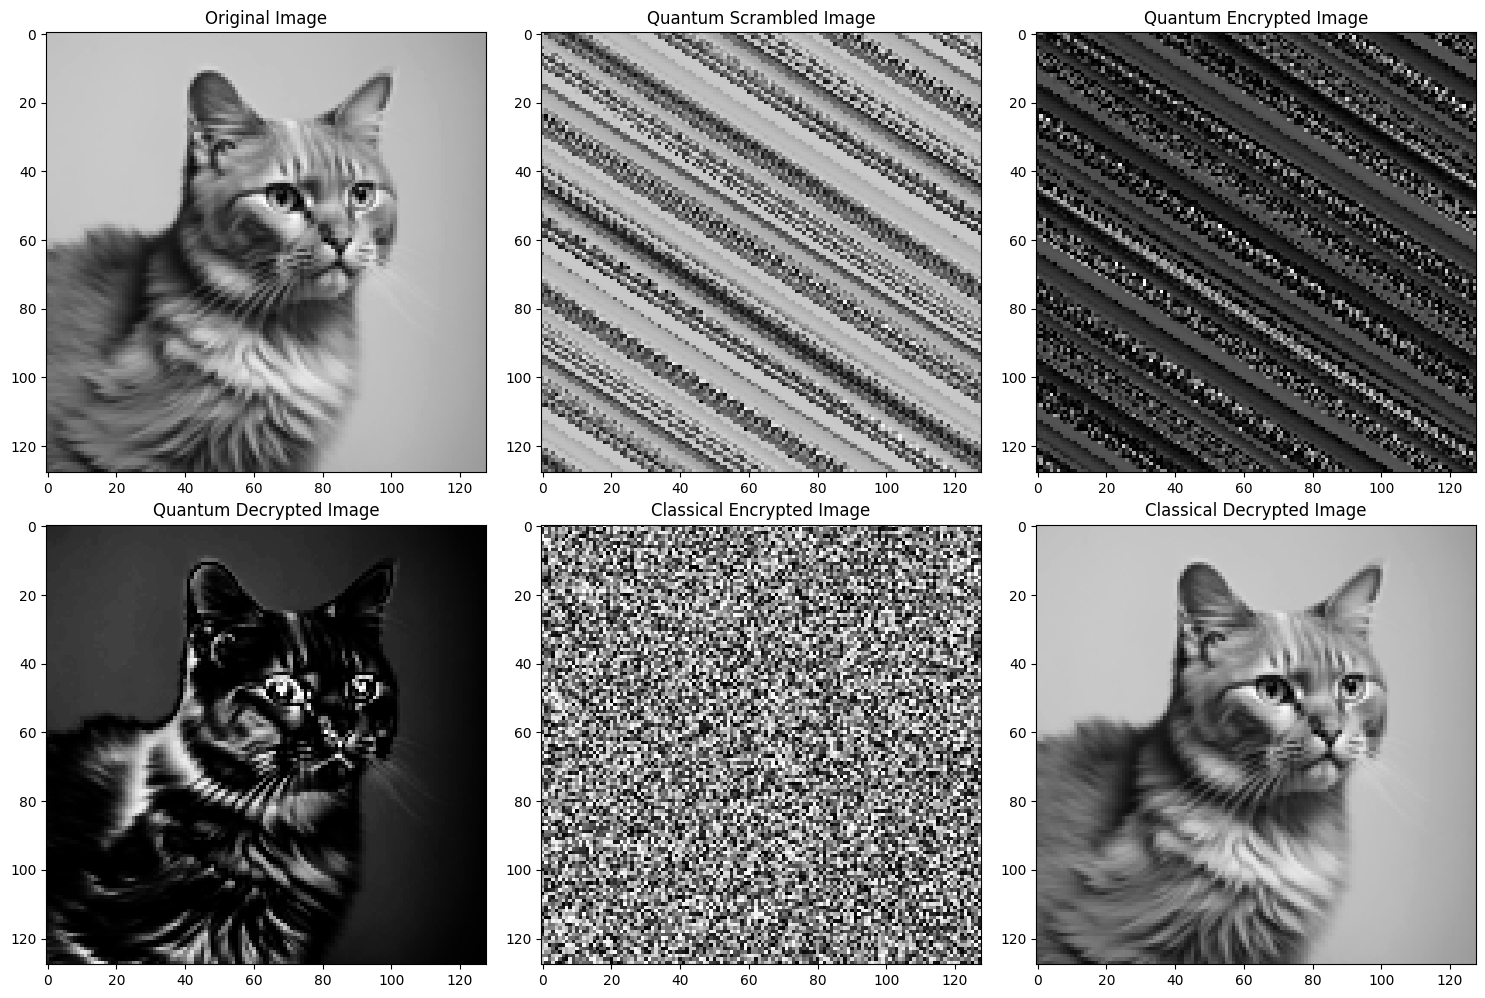

Quantum Encryption:
Entropy: 9.682164683801041
Correlation (Horizontal, Vertical): (0.1821555263433427, 0.15699156496142694)
PSNR (Original vs Encrypted): -2.76 dB
PSNR (Original vs Decrypted): -2.58 dB

Classical Encryption:
Entropy: 9.507935473026732
Correlation (Horizontal, Vertical): (-0.008042892221020857, -0.01518922368243952)
PSNR (Original vs Encrypted): 8.84 dB
PSNR (Original vs Decrypted): inf dB


In [4]:
import pennylane as qml
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from scipy.stats import entropy

# Load and preprocess image
img = Image.open('/content/out-0-1.png').convert('L')
img = img.resize((128, 128))  # Resize to a manageable size
img_array = np.array(img) / 255.0  # Normalize pixel values

# Define quantum device
n_qubits = 10  # Adjust based on the image size
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum Logistic Map
def quantum_logistic_map(seed, size):
    x = seed
    key = []
    for _ in range(size):
        x = 3.9 * x * (1 - x)  # Logistic map equation
        key.append(x)
    return key

# Quantum Arnold Transform (scrambling)
def quantum_arnold_scramble(img, iterations):
    n = img.shape[0]
    scrambled_img = img.copy()
    for _ in range(iterations):
        new_img = np.zeros_like(scrambled_img)
        for x in range(n):
            for y in range(n):
                new_x = (x + y) % n
                new_y = (x + 2 * y) % n
                new_img[new_x, new_y] = scrambled_img[x, y]
        scrambled_img = new_img
    return scrambled_img

# Inverse Quantum Arnold Transform
def inverse_quantum_arnold_scramble(img, iterations):
    n = img.shape[0]
    unscrambled_img = img.copy()
    for _ in range(iterations):
        new_img = np.zeros_like(unscrambled_img)
        for x in range(n):
            for y in range(n):
                new_x = (2 * x - y) % n
                new_y = (-x + y) % n
                new_img[new_x, new_y] = unscrambled_img[x, y]
        unscrambled_img = new_img
    return unscrambled_img

@qml.qnode(dev)
def enhanced_encryption_circuit(img_pixel, key):
    # Initialize qubits with superposition
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Layer 1: Controlled entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Apply pixel-based rotation on first qubit
    qml.RY(img_pixel * np.pi, wires=0)

    # Key-based rotations (diffusion)
    for i in range(n_qubits):
        qml.RZ(key[i % len(key)] * np.pi, wires=i)

    # Layer 2: Additional entanglement with controlled-phase gates
    for i in range(n_qubits - 1):
        qml.CRX(np.pi / 2, wires=[i, i + 1])

    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def enhanced_decryption_circuit(cipher_pixel, key):
    # Reverse Layer 2
    for i in range(n_qubits - 1):
        qml.CRX(-np.pi / 2, wires=[i, i + 1])

    # Reverse key-based rotations
    for i in range(n_qubits):
        qml.RZ(-key[i % len(key)] * np.pi, wires=i)

    # Reverse Layer 1
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Reverse pixel rotation
    qml.RY(-cipher_pixel * np.pi, wires=0)

    return qml.expval(qml.PauliZ(0))

# Apply Quantum Logistic Map for Key Generation
key = quantum_logistic_map(0.7, n_qubits)

# Quantum Encryption
scrambled_img = quantum_arnold_scramble(img_array, 3)  # Apply Arnold Transform
quantum_encrypted_pixels = [enhanced_encryption_circuit(pixel, key) for pixel in scrambled_img.flatten()]
quantum_encrypted_img = np.array(quantum_encrypted_pixels).reshape(scrambled_img.shape)

# Quantum Decryption
quantum_decrypted_pixels = [enhanced_decryption_circuit(pixel, key) for pixel in quantum_encrypted_img.flatten()]
unscrambled_img = inverse_quantum_arnold_scramble(np.array(quantum_decrypted_pixels).reshape(scrambled_img.shape), 3)

# Metrics for Comparison
def correlation_coefficient(img):
    horizontal = np.corrcoef(img[:, :-1].flatten(), img[:, 1:].flatten())[0, 1]
    vertical = np.corrcoef(img[:-1, :].flatten(), img[1:, :].flatten())[0, 1]
    return horizontal, vertical

quantum_entropy = entropy(quantum_encrypted_img.flatten())
quantum_corr = correlation_coefficient(quantum_encrypted_img)

# PSNR Calculation
def psnr(original, compared):
    mse = np.mean((original - compared) ** 2)
    if mse == 0:
        return float('inf')  # If MSE is zero, the PSNR is infinite
    max_pixel = 1.0  # As the images are normalized between 0 and 1
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Calculate PSNR for the encrypted and decrypted images
psnr_encrypted = psnr(img_array, quantum_encrypted_img)
psnr_decrypted = psnr(img_array, unscrambled_img)

# Classical XOR Encryption and Decryption
def classical_encrypt(image, key):
    """Encrypt the image using XOR with a key."""
    encrypted_image = np.bitwise_xor((image * 255).astype(np.uint8), key).astype(float) / 255.0
    return encrypted_image

def classical_decrypt(encrypted_image, key):
    """Decrypt the image using XOR with the same key."""
    decrypted_image = np.bitwise_xor((encrypted_image * 255).astype(np.uint8), key).astype(float) / 255.0
    return decrypted_image

# Generate a simple key for XOR encryption
classical_key = np.random.randint(0, 256, size=img_array.shape, dtype=np.uint8)

# Perform Classical Encryption
classical_encrypted_img = classical_encrypt(img_array, classical_key)

# Perform Classical Decryption
classical_decrypted_img = classical_decrypt(classical_encrypted_img, classical_key)

# Compute Metrics for Classical Encryption
classical_entropy = entropy(classical_encrypted_img.flatten())
classical_corr = correlation_coefficient(classical_encrypted_img)
psnr_classical_encrypted = psnr(img_array, classical_encrypted_img)
psnr_classical_decrypted = psnr(img_array, classical_decrypted_img)

# Display Results
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(img_array, cmap='gray')
plt.title("Original Image")

plt.subplot(2, 3, 2)
plt.imshow(scrambled_img, cmap='gray')
plt.title("Quantum Scrambled Image")

plt.subplot(2, 3, 3)
plt.imshow(quantum_encrypted_img, cmap='gray')
plt.title("Quantum Encrypted Image")

plt.subplot(2, 3, 4)
plt.imshow(unscrambled_img, cmap='gray')
plt.title("Quantum Decrypted Image")

plt.subplot(2, 3, 5)
plt.imshow(classical_encrypted_img, cmap='gray')
plt.title("Classical Encrypted Image")

plt.subplot(2, 3, 6)
plt.imshow(classical_decrypted_img, cmap='gray')
plt.title("Classical Decrypted Image")

plt.tight_layout()
plt.show()

# Output Metrics
print("Quantum Encryption:")
print(f"Entropy: {quantum_entropy}")
print(f"Correlation (Horizontal, Vertical): {quantum_corr}")
print(f"PSNR (Original vs Encrypted): {psnr_encrypted:.2f} dB")
print(f"PSNR (Original vs Decrypted): {psnr_decrypted:.2f} dB")

print("\nClassical Encryption:")
print(f"Entropy: {classical_entropy}")
print(f"Correlation (Horizontal, Vertical): {classical_corr}")
print(f"PSNR (Original vs Encrypted): {psnr_classical_encrypted:.2f} dB")
print(f"PSNR (Original vs Decrypted): {psnr_classical_decrypted:.2f} dB")

